In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the gold-standard and VLM-predicted label datasets
file_gold = "mimic-cxr-gold-standard.xlsx"
file_deepseek = "labels_DeepSeek_fixed.xlsx"  # DeepSeek VL2 predictions
file_cxr_llava = "labels_CXR_LLaVA_fixed.xlsx"  # CXR_LLaVA predictions
file_cxr_chexagent = "labels_cheXagent_fixed.xlsx"  # cheXagent predictions

df_gold = pd.read_excel(file_gold)
df_deepseek = pd.read_excel(file_deepseek)
df_cxr_llava = pd.read_excel(file_cxr_llava)
df_cxr_chexagent = pd.read_excel(file_cxr_chexagent)

# Define the 13 conditions
conditions = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

# Replace NaN values with -2 (indicating "not mentioned")
for df in [df_gold, df_deepseek, df_cxr_llava, df_cxr_chexagent]:
    df[conditions] = df[conditions].fillna(-2).astype(int)

# Define error types and descriptions
error_types = {
    (1, 0):  "False Negative (Wrong Negation): 1 → 0",
    (1, -1): "False Negative (Uncertainty Downgrade): 1 → -1",
    (1, -2): "Omission (Missed Finding): 1 → -2",
    (0, 1):  "False Positive (Wrong Affirmation): 0 → 1",
    (0, -1): "False Positive (Uncertainty Introduction): 0 → -1",
    (0, -2): "Omission (Removed Negative Evidence): 0 → -2",
    (-2, 1): "Hallucination (Nonexistent Condition): -2 → 1",
    (-2, 0): "False Certainty (Wrong Negation): -2 → 0",
    (-2, -1): "False Certainty (Incorrect Uncertainty): -2 → -1",
    (-1, 1): "Uncertainty Overconfidence (False Positive): -1 → 1",
    (-1, 0): "Uncertainty Underconfidence (False Negative): -1 → 0",
    (-1, -2): "Uncertainty Omission (Dropped Finding): -1 → -2",
}

# Define clinical risk levels
risk_levels = {
    "False Negative (Wrong Negation)": "High",
    "False Negative (Uncertainty Downgrade)": "High",
    "Omission (Missed Finding)": "High",
    "False Positive (Wrong Affirmation)": "Medium",
    "False Positive (Uncertainty Introduction)": "Medium",
    "Omission (Removed Negative Evidence)": "Low",
    "Hallucination (Nonexistent Condition)": "High",
    "False Certainty (Wrong Negation)": "Low",
    "False Certainty (Incorrect Uncertainty)": "Medium",
    "Uncertainty Overconfidence (False Positive)": "Medium",
    "Uncertainty Underconfidence (False Negative)": "High",
    "Uncertainty Omission (Dropped Finding)": "High"
}

# Initialize error and risk tracking
models = {"DeepSeek": df_deepseek, "CXR-LLaVA": df_cxr_llava, "CheXagent":df_cxr_chexagent}
error_counts = {model: {error: 0 for error in error_types.values()} for model in models}
condition_counts = {model: {cond: 0 for cond in conditions} for model in models}
risk_counts = {model: {"High": 0, "Medium": 0, "Low": 0} for model in models}

# Count errors per model
for model_name, df_model in models.items():
    for condition in conditions:
        for gt, pred in zip(df_gold[condition], df_model[condition]):
            if (gt, pred) in error_types:
                error_name = error_types[(gt, pred)]
                error_counts[model_name][error_name] += 1
                condition_counts[model_name][condition] += 1
                risk_counts[model_name][risk_levels[error_name.split(":")[0]]] += 1

# Convert to DataFrame for visualization
df_error_counts = pd.DataFrame(error_counts)
df_condition_counts = pd.DataFrame(condition_counts)
df_risk_counts = pd.DataFrame(risk_counts)


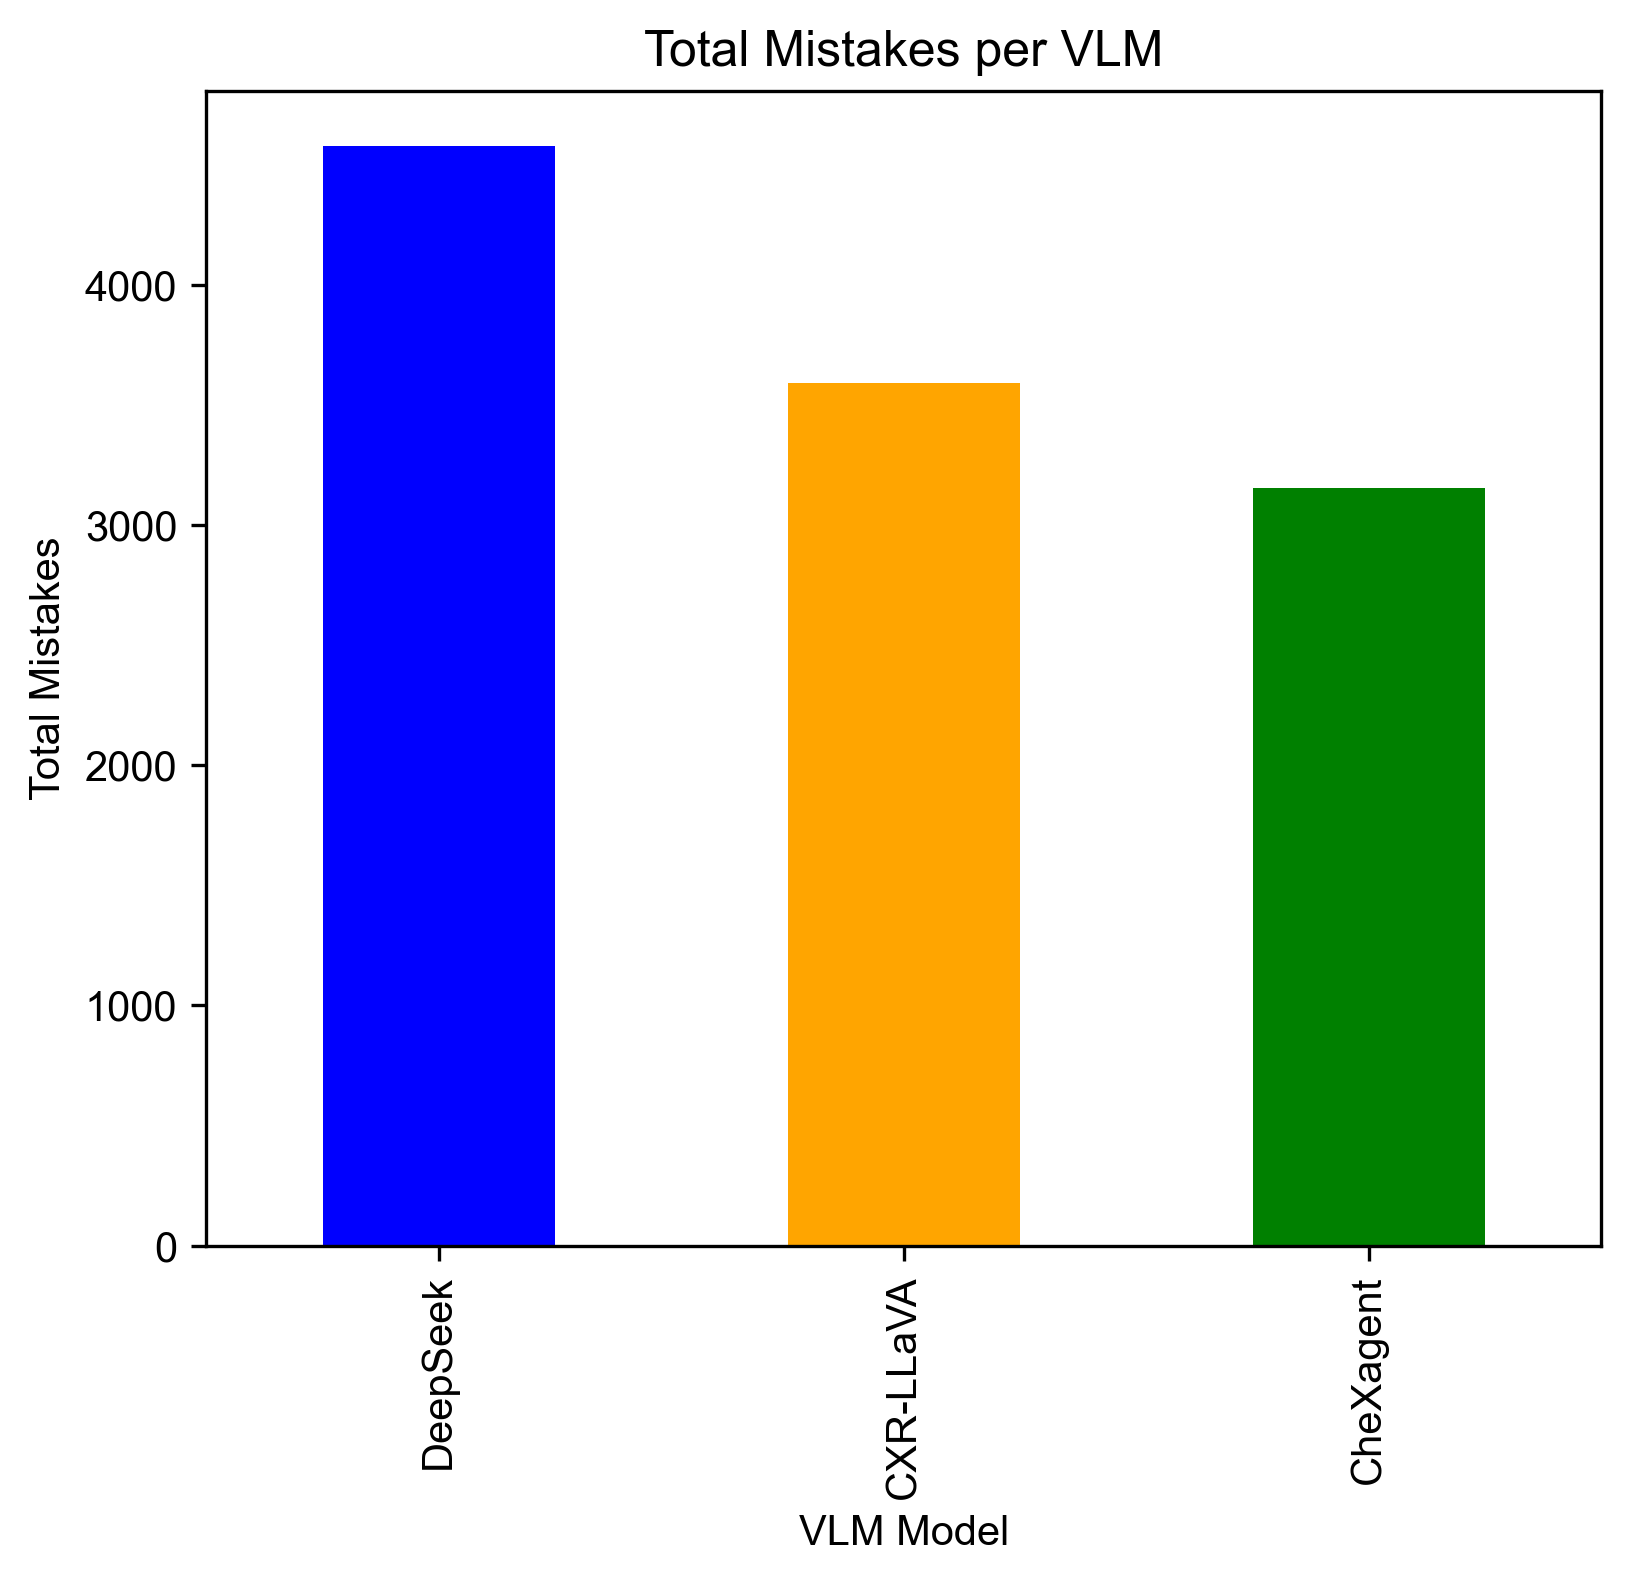

In [33]:
# Plot total mistakes
plt.figure(figsize=(6, 5), dpi=300)
df_error_counts.sum().plot(kind="bar", color=["blue", "orange","green"])
plt.xlabel("VLM Model")
plt.ylabel("Total Mistakes")
plt.title("Total Mistakes per VLM")
plt.savefig("total_mistakes.png", dpi=300, bbox_inches="tight")
plt.savefig("total_mistakes.pdf", bbox_inches="tight")
plt.show()

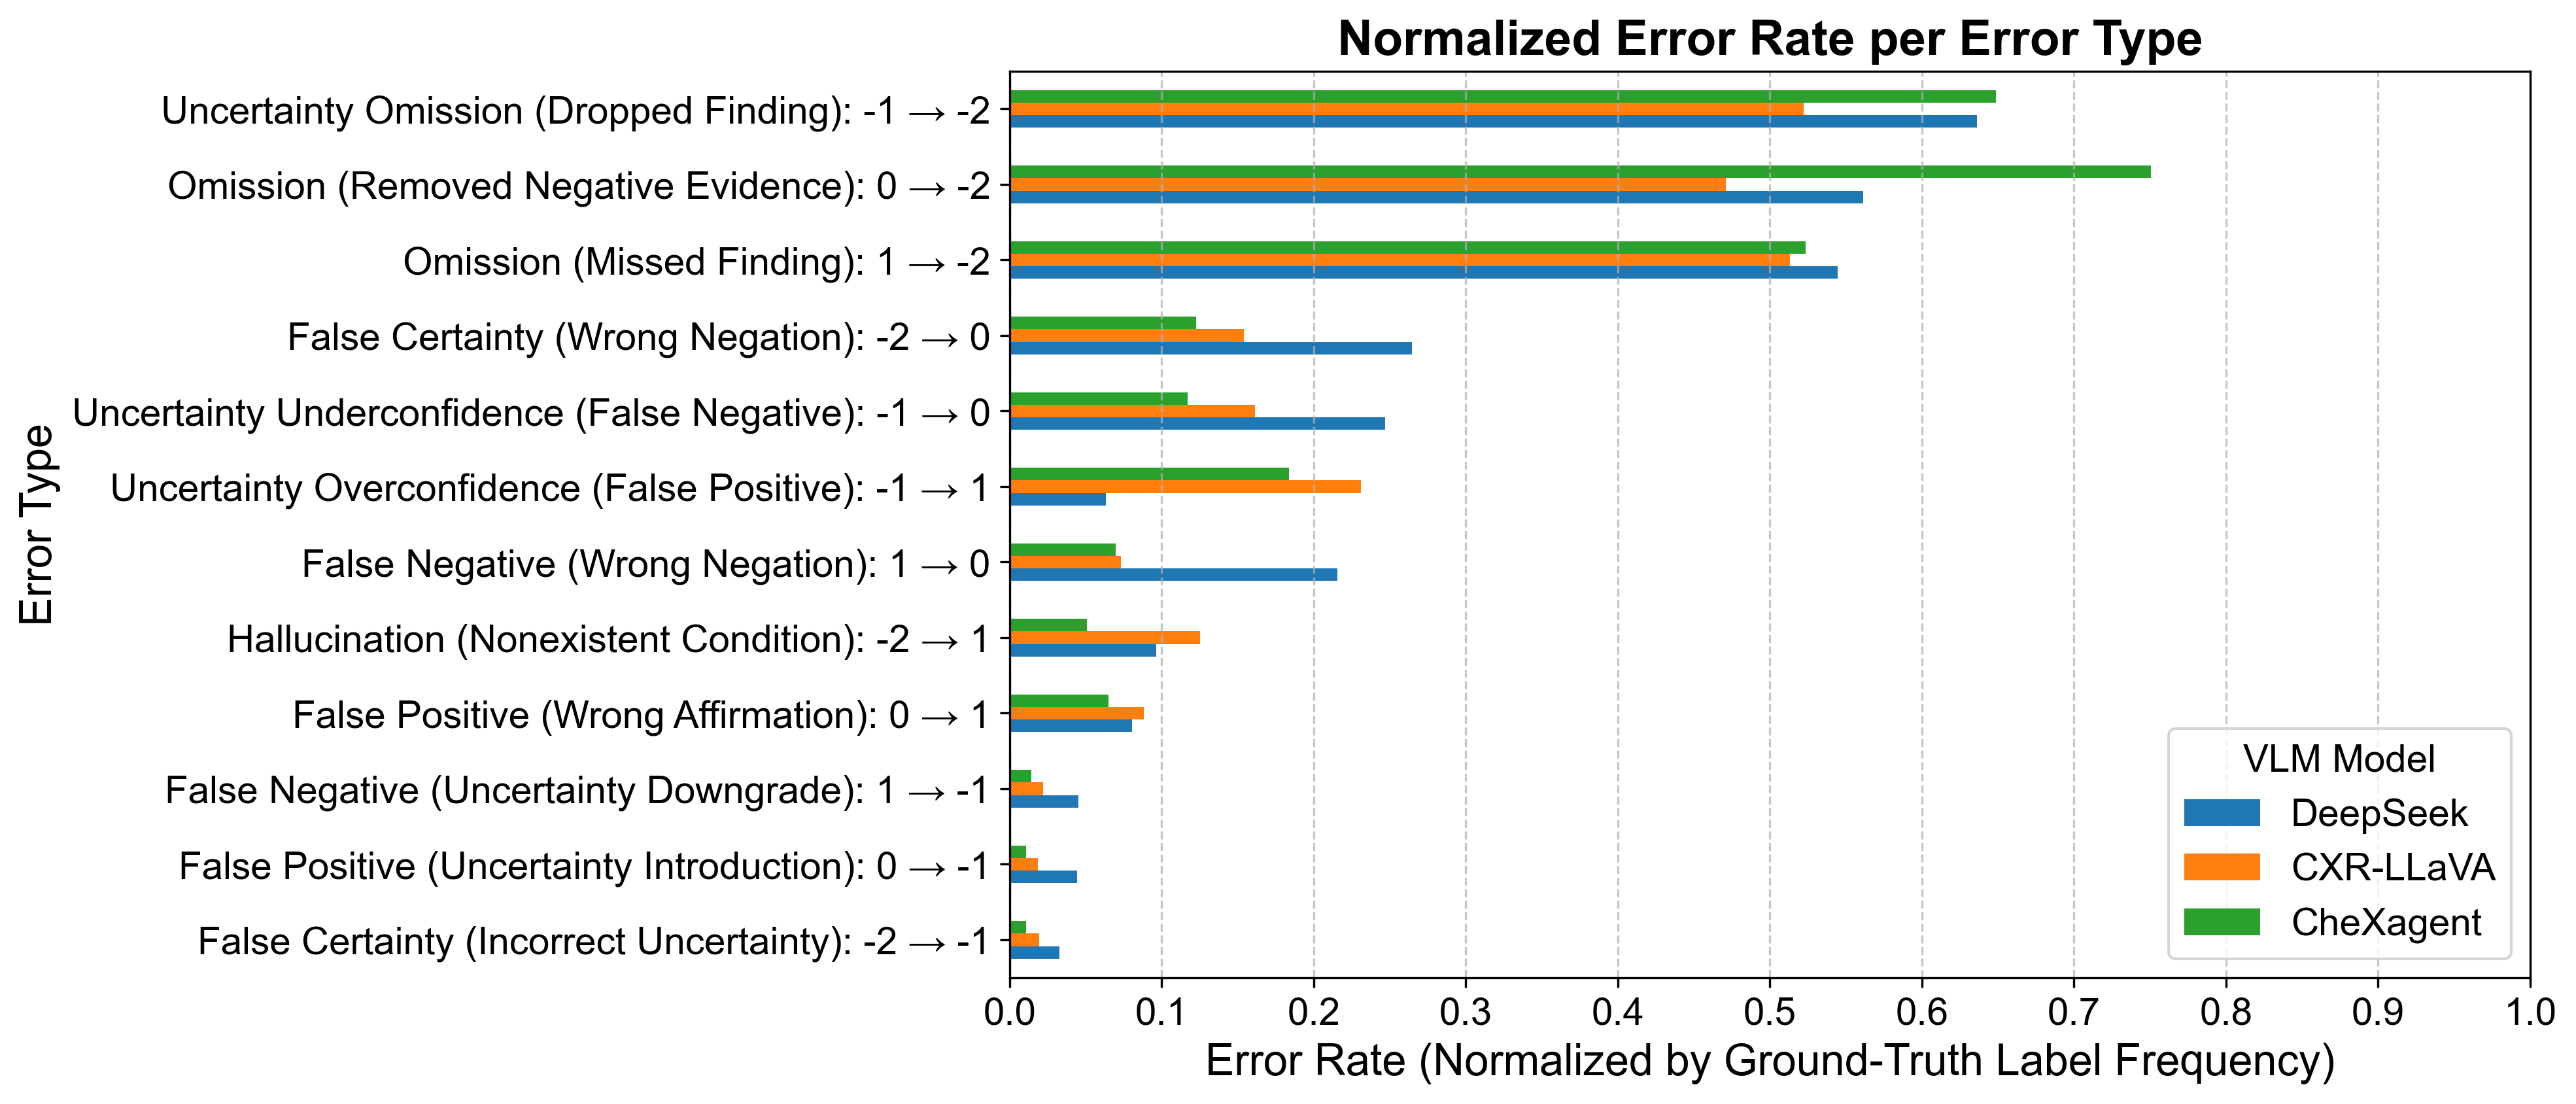

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import matplotlib
import numpy as np
matplotlib.rcParams['font.family'] = 'Arial'

# Load data
file_gold = "mimic-cxr-gold-standard.xlsx"
file_deepseek = "labels_DeepSeek_fixed.xlsx"
file_cxr_llava = "labels_CXR_LLaVA_fixed.xlsx"
file_cxr_chexagent = "labels_cheXagent_fixed.xlsx"

df_gold = pd.read_excel(file_gold)
df_deepseek = pd.read_excel(file_deepseek)
df_cxr_llava = pd.read_excel(file_cxr_llava)
df_cxr_chexagent = pd.read_excel(file_cxr_chexagent)

# Define conditions
conditions = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

# Replace NaN with -2
for df in [df_gold, df_deepseek, df_cxr_llava, df_cxr_chexagent]:
    df[conditions] = df[conditions].fillna(-2).astype(int)

# Define error types
error_types = {
    (1, 0):  "False Negative (Wrong Negation): 1 → 0",
    (1, -1): "False Negative (Uncertainty Downgrade): 1 → -1",
    (1, -2): "Omission (Missed Finding): 1 → -2",
    (0, 1):  "False Positive (Wrong Affirmation): 0 → 1",
    (0, -1): "False Positive (Uncertainty Introduction): 0 → -1",
    (0, -2): "Omission (Removed Negative Evidence): 0 → -2",
    (-2, 1): "Hallucination (Nonexistent Condition): -2 → 1",
    (-2, 0): "False Certainty (Wrong Negation): -2 → 0",
    (-2, -1): "False Certainty (Incorrect Uncertainty): -2 → -1",
    (-1, 1): "Uncertainty Overconfidence (False Positive): -1 → 1",
    (-1, 0): "Uncertainty Underconfidence (False Negative): -1 → 0",
    (-1, -2): "Uncertainty Omission (Dropped Finding): -1 → -2",
}

# Define models
models = {"DeepSeek": df_deepseek, "CXR-LLaVA": df_cxr_llava, "CheXagent": df_cxr_chexagent}
error_counts = {model: {error: 0 for error in error_types.values()} for model in models}

# Count errors
for model_name, df_model in models.items():
    for condition in conditions:
        for gt, pred in zip(df_gold[condition], df_model[condition]):
            if (gt, pred) in error_types:
                error_name = error_types[(gt, pred)]
                error_counts[model_name][error_name] += 1

# Convert to DataFrame
df_error_counts = pd.DataFrame(error_counts)


# Count GT label distribution
gt_label_counts = Counter()
for condition in conditions:
    gt_label_counts.update(df_gold[condition].values)

# Map each error type to its GT label
error_gt_label_map = {error_types[k]: k[0] for k in error_types}

# Normalize error counts
#df_error_counts_normalized = df_error_counts.copy()
df_error_counts_normalized = df_error_counts.astype(float)
for err_type in df_error_counts.index:
    gt_label = error_gt_label_map[err_type]
    total_gt = gt_label_counts[gt_label]
    if total_gt > 0:
        df_error_counts_normalized.loc[err_type] = (df_error_counts.loc[err_type] / total_gt).astype(float)
    else:
        df_error_counts_normalized.loc[err_type] = 0.0

# Sort normalized results
df_error_counts_normalized["Mean"] = df_error_counts_normalized.mean(axis=1)
df_error_counts_normalized = df_error_counts_normalized.sort_values(by="Mean", ascending=True).drop(columns="Mean")


# Set Arial font globally
matplotlib.rcParams["font.family"] = "Arial"

# Create a wide and tall-enough figure for spacing between bars
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)

# Plot
df_error_counts_normalized.plot(kind="barh", ax=ax)

# Axis labels and title
ax.set_xlabel("Error Rate (Normalized by Ground-Truth Label Frequency)", fontsize=16)
ax.set_ylabel("Error Type", fontsize=16)
ax.set_title("Normalized Error Rate per Error Type", fontsize=18, fontweight="bold")
ax.tick_params(labelsize=14)  # Set font size of tick labels


# x-axis ticks
ax.set_xlim(0, 1.0)
ax.set_xticks(np.arange(0, 1.1, 0.1))

# Legend inside plot box (top right)
ax.legend(
    title="VLM Model",
    fontsize=14,
    title_fontsize=14,
    loc='lower right',
    frameon=True
)

# Grid and margin
ax.grid(axis='x', linestyle='--', alpha=0.7)
#plt.subplots_adjust(left=0.30, right=0.95)  # allow space for long labels and legend

# Save high-resolution images
plt.savefig("normalized_error_rates.png", dpi=300, bbox_inches="tight")
plt.savefig("normalized_error_rates.pdf", dpi=300, bbox_inches="tight")

# Show plot
plt.show()



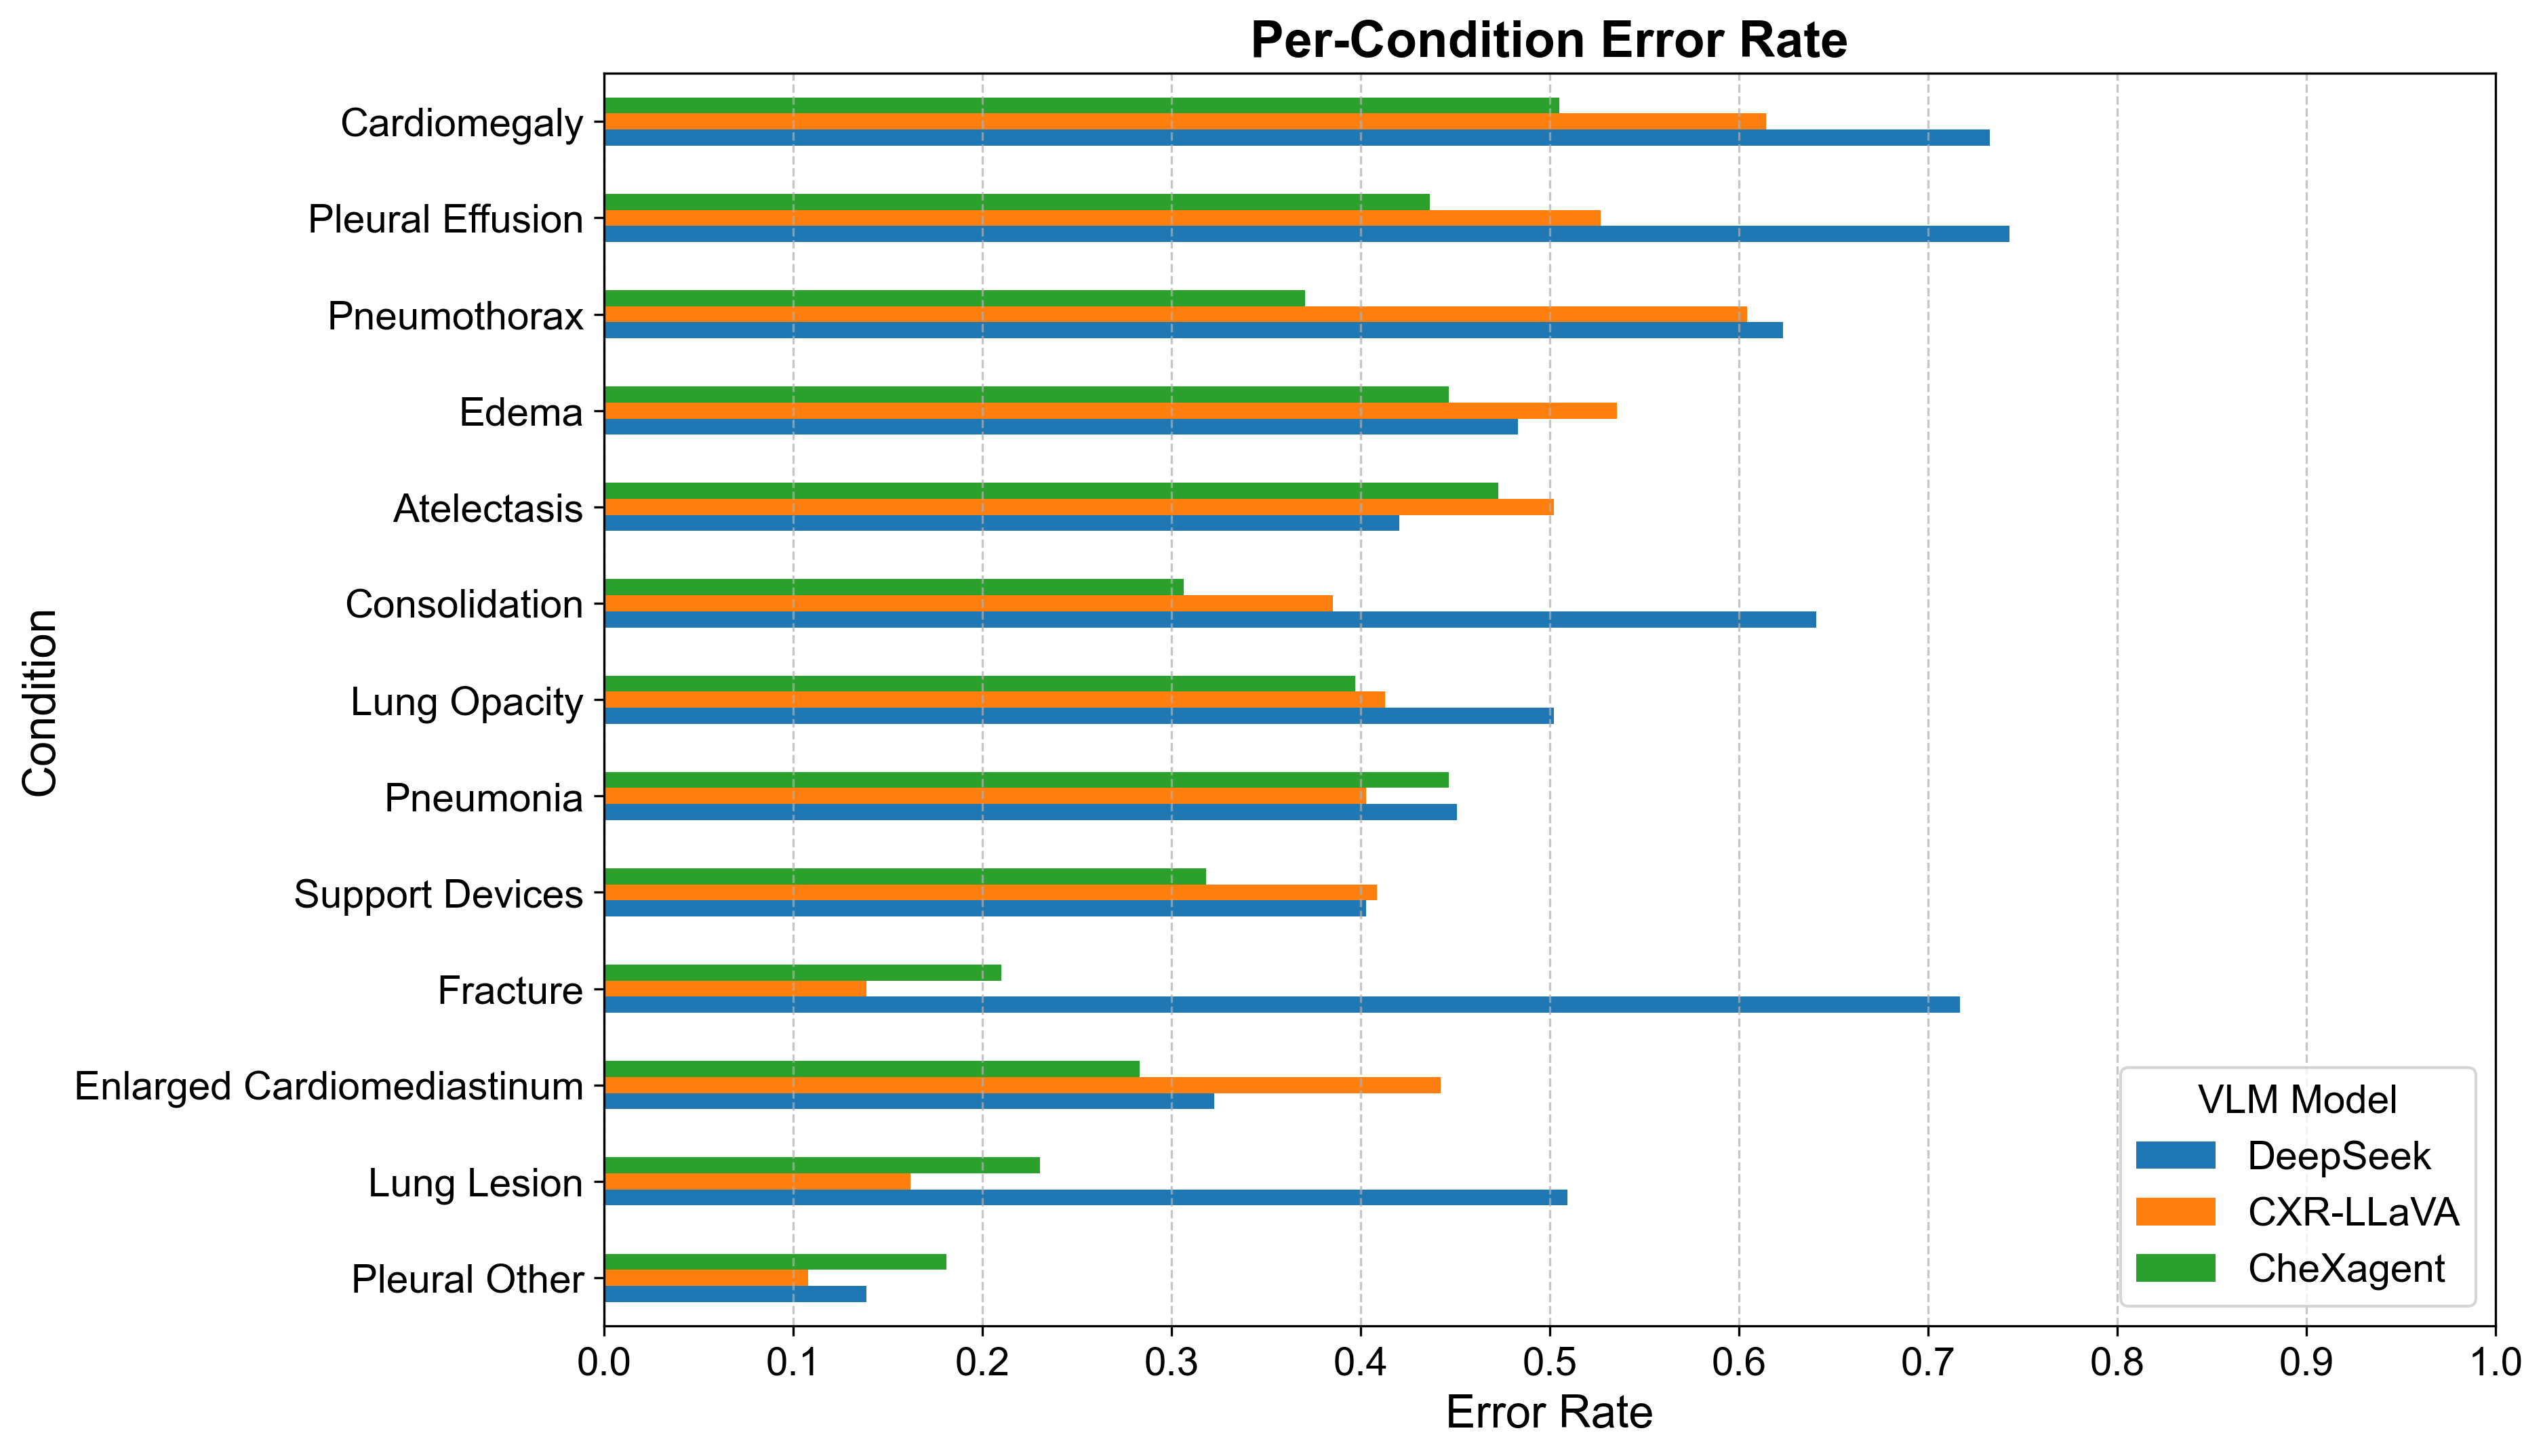

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

# Set global font to Arial
matplotlib.rcParams["font.family"] = "Arial"

# Load files
file_gold = "mimic-cxr-gold-standard.xlsx"
file_deepseek = "labels_DeepSeek_fixed.xlsx"
file_cxr_llava = "labels_CXR_LLaVA_fixed.xlsx"
file_cxr_chexagent = "labels_cheXagent_fixed.xlsx"

df_gold = pd.read_excel(file_gold)
df_deepseek = pd.read_excel(file_deepseek)
df_cxr_llava = pd.read_excel(file_cxr_llava)
df_cxr_chexagent = pd.read_excel(file_cxr_chexagent)

# Define 13 clinical conditions
conditions = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

# Replace missing labels with -2
for df in [df_gold, df_deepseek, df_cxr_llava, df_cxr_chexagent]:
    df[conditions] = df[conditions].fillna(-2).astype(int)

# Compute per-condition error rate (include all GT labels)
models = {
    "DeepSeek": df_deepseek,
    "CXR-LLaVA": df_cxr_llava,
    "CheXagent": df_cxr_chexagent
}

error_rates = {model: {} for model in models}
for model_name, df_model in models.items():
    for condition in conditions:
        total = 0
        errors = 0
        for gt, pred in zip(df_gold[condition], df_model[condition]):
            total += 1
            if gt != pred:
                errors += 1
        error_rates[model_name][condition] = errors / total if total > 0 else 0

# Create DataFrame and sort
df_error_rates = pd.DataFrame(error_rates)
#df_sorted = df_error_rates.sort_values(by="DeepSeek", ascending=True)
df_sorted = df_error_rates.copy()
df_sorted["Mean"] = df_sorted.mean(axis=1)
df_sorted = df_sorted.sort_values(by="Mean").drop(columns="Mean")

# Plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=300)
df_sorted.plot(kind="barh", ax=ax)

# Format
ax.set_xlabel("Error Rate", fontsize=16)
ax.set_ylabel("Condition", fontsize=16)
ax.set_title("Per-Condition Error Rate", fontsize=18, fontweight="bold")
ax.tick_params(labelsize=14)
ax.set_xlim(0, 1.0)
ax.set_xticks(np.arange(0, 1.1, 0.1))
ax.legend(title="VLM Model", fontsize=14, title_fontsize=14, loc='lower right', frameon=True)
ax.grid(axis='x', linestyle='--', alpha=0.7)

# Save
plt.savefig("condition_error_rate.png", dpi=300, bbox_inches="tight")
plt.savefig("condition_error_rate.pdf", dpi=300, bbox_inches="tight")
plt.show()


<Figure size 2400x1800 with 0 Axes>

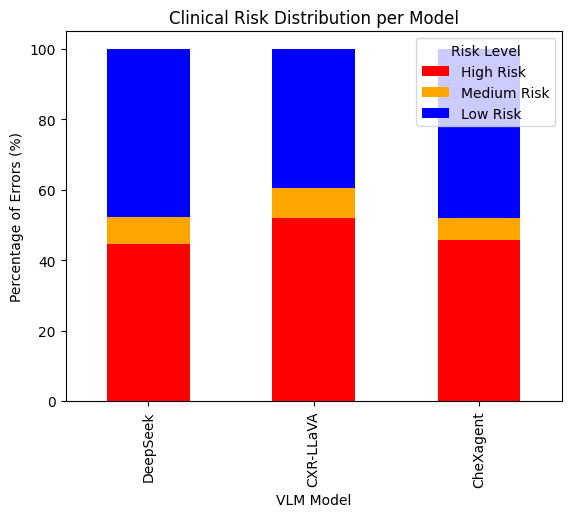

In [15]:
# Plot clinical risk levels (stacked bar chart)
df_risk_proportion = df_risk_counts.div(df_risk_counts.sum(axis=0), axis=1) * 100
plt.figure(figsize=(8, 6), dpi=300)
df_risk_proportion.T.plot(kind="bar", stacked=True, color=["red", "orange", "blue"])
plt.xlabel("VLM Model")
plt.ylabel("Percentage of Errors (%)")
plt.title("Clinical Risk Distribution per Model")
plt.legend(title="Risk Level", labels=["High Risk", "Medium Risk", "Low Risk"])
plt.savefig("clinical_risk_per_model.png", dpi=300, bbox_inches="tight")
plt.savefig("clinical_risk_per_model.pdf", bbox_inches="tight")
plt.show()

In [8]:
import pandas as pd

# Load files
df_gold = pd.read_excel("mimic-cxr-gold-standard.xlsx")
df_deepseek = pd.read_excel("labels_DeepSeek_fixed.xlsx")
df_cxr_llava = pd.read_excel("labels_CXR_LLaVA_fixed.xlsx")
df_cxr_chexagent = pd.read_excel("labels_cheXagent_fixed.xlsx")

# Define conditions
conditions = [
    "Enlarged Cardiomediastinum", "Cardiomegaly", "Lung Lesion",
    "Lung Opacity", "Edema", "Consolidation", "Pneumonia",
    "Atelectasis", "Pneumothorax", "Pleural Effusion", "Pleural Other",
    "Fracture", "Support Devices"
]

# Clean NaNs
for df in [df_gold, df_deepseek, df_cxr_llava, df_cxr_chexagent]:
    df[conditions] = df[conditions].fillna(-2).astype(int)

# Error type → label
error_types = {
    (1, 0):  "False Negative (Wrong Negation)",
    (1, -1): "False Negative (Uncertainty Downgrade)",
    (1, -2): "Omission (Missed Finding)",
    (0, 1):  "False Positive (Wrong Affirmation)",
    (0, -1): "False Positive (Uncertainty Introduction)",
    (0, -2): "Omission (Removed Negative Evidence)",
    (-2, 1): "Hallucination (Nonexistent Condition)",
    (-2, 0): "False Certainty (Wrong Negation)",
    (-2, -1): "False Certainty (Incorrect Uncertainty)",
    (-1, 1): "Uncertainty Overconfidence (False Positive)",
    (-1, 0): "Uncertainty Underconfidence (False Negative)",
    (-1, -2): "Uncertainty Omission (Dropped Finding)",
}

# Risk levels
risk_levels = {
    "False Negative (Wrong Negation)": "High",
    "False Negative (Uncertainty Downgrade)": "High",
    "Omission (Missed Finding)": "High",
    "False Positive (Wrong Affirmation)": "Medium",
    "False Positive (Uncertainty Introduction)": "Medium",
    "Omission (Removed Negative Evidence)": "Low",
    "Hallucination (Nonexistent Condition)": "High",
    "False Certainty (Wrong Negation)": "Low",
    "False Certainty (Incorrect Uncertainty)": "Medium",
    "Uncertainty Overconfidence (False Positive)": "Medium",
    "Uncertainty Underconfidence (False Negative)": "High",
    "Uncertainty Omission (Dropped Finding)": "High"
}

# Model dictionary
models = {
    "DeepSeek": df_deepseek,
    "CXR-LLaVA": df_cxr_llava,
    "CheXagent": df_cxr_chexagent
}

# Step 1: Count raw risk level frequencies
risk_counts = {model: {"High": 0, "Medium": 0, "Low": 0} for model in models}

for model_name, df_pred in models.items():
    for cond in conditions:
        for gt, pred in zip(df_gold[cond], df_pred[cond]):
            if (gt, pred) in error_types:
                error_type = error_types[(gt, pred)]
                risk_level = risk_levels[error_type]
                risk_counts[model_name][risk_level] += 1

# Step 2: Convert to DataFrame and compute proportions
df_counts = pd.DataFrame(risk_counts).T
df_proportions = df_counts.div(df_counts.sum(axis=1), axis=0)

# Step 3: Save both to Excel
with pd.ExcelWriter("risk_level_counts_and_proportions.xlsx") as writer:
    df_counts.to_excel(writer, sheet_name="Counts")
    df_proportions.to_excel(writer, sheet_name="Proportions")

# Display
print("=== Risk Level Counts ===")
print(df_counts)
print("\n=== Risk Level Proportions ===")
print(df_proportions)


=== Risk Level Counts ===
           High  Medium   Low
DeepSeek   2047     347  2187
CXR-LLaVA  1871     301  1421
CheXagent  1442     200  1513

=== Risk Level Proportions ===
               High    Medium       Low
DeepSeek   0.446846  0.075748  0.477407
CXR-LLaVA  0.520735  0.083774  0.395491
CheXagent  0.457052  0.063391  0.479556
